<a href="https://colab.research.google.com/github/vchandraiitk/PokerCardGame/blob/master/Vikas_M3_MP4_NB_Employee_Attrition_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science
## A program by IISc and TalentSprint
### Mini Project Notebook: Employee Attrition Prediction

## **Note:** This notebook is part of an in-house Kaggle competition

## Problem Statement

To predict employee attrition using CatBoost and XgBoost

## Learning Objectives

At the end of the experiment, you will be able to

* explore the employee attrition dataset
* apply CatBoost and XgBoost on the dataset
* tune the model hyperparameters to improve accuracy
* evaluate the model using suitable metrics


## Introduction

Employee attrition is the gradual reduction in employee numbers. Employee attrition happens when the size of your workforce diminishes over time. This means that employees are leaving faster than they are hired. Employee attrition happens when employees retire, resign, or simply aren't replaced.
Although employee attrition can be company-wide, it may also be confined to specific parts of a business.

Employee attrition can happen for several reasons. These include unhappiness about employee benefits or the pay structure, a lack of employee development opportunities, and even poor conditions in the workplace.

To know more about the factors that lead to employee attrition, refer [here](https://www.betterup.com/blog/employee-attrition#:~:text=Employee%20attrition%20is%20the%20gradual,or%20simply%20aren't%20replaced).


**Gradient Boosted Decision Trees**

* Gradient boosted decision trees (GBDTs) are one of the most important machine learning models.

* GBDTs originate from AdaBoost, an algorithm that ensembles weak learners and uses the majority vote, weighted by their individual accuracy, to solve binary classification problems. The weak learners in this case are decision trees with a single split, called decision stumps.

* Some of the widely used gradient boosted decision trees are XgBoost, CatBoost and LightGBM.

## Dataset

The dataset used for this mini-project is [HR Employee Attrition dataset](https://data.world/aaizemberg/hr-employee-attrition). This dataset is synthetically created by IBM data scientists. There are 35 features and 1470 records.

There are numerical features such as:

* Age
* DistanceFromHome
* EmployeeNumber
* PerformanceRating

There are several categorical features such as:
* JobRole
* EducationField
* Department
* BusinessTravel

Dependent or target feature is 'attrition' which has values as Yes/No.

### **Kaggle Competition**

Please refer to the link for viewing the
[Kaggle Competition Document](https://drive.google.com/file/d/1bJXXxoH5-wZbG0cXDDJUkzFUO564A2XG/view?usp=drive_link) and join the Kaggle Competition using the hyperlink given in this document under '*Kaggle* Competition site'.

## Grading = 10 Points

In [370]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [371]:
import os
os.chdir('/content/drive/MyDrive/ISC/MiniProject/M3_MP4_NB_Employee_Attrition_Prediction')

In [372]:
#@title Download the data
#!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/hr_employee_attrition_train.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


### Install CatBoost

In [373]:
!pip -qq install catboost

### Import Required Packages

In [374]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, metrics
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
%matplotlib inline

## Load the Dataset

**Exercise 1: Read the dataset [0.5 Mark]**

**Hint:** pd.read_csv()

In [375]:
# read the dataset
# YOUR CODE HERE
df_attrition_train = pd.read_csv('hr_employee_attrition_train.csv')
df_attrition_test = pd.read_csv('hr_employee_attrition_test.csv')

columns_to_drop = ['employeenumber', 'employeecount', 'over18', 'yearsatcompany', 'joblevel']
test_ids = df_attrition_test['id']
df_attrition_train.drop(columns_to_drop, axis=1, inplace=True)
df_attrition_test.drop(columns_to_drop+ ['id'], axis=1, inplace=True)

In [376]:
# Check the shape of dataframe.
# YOUR CODE HERE
len(df_attrition_train.columns), len(df_attrition_test.columns)

(30, 29)

There can be more than one file to read as this is introduced as a competition, dataset has one file for training the model. Their can be other files as one containing the test features and the other can be the true labels.

## Data Exploration

- Check for missing values
- Check for consistent data type across a feature
- Check for outliers or inconsistencies in data columns
- Check for correlated features
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships? Making correlation heatmaps makes it easy to identify possible collinearity

**Exercise 2: Create a `List` of numerical and categorical columns. Display a statistical description of the dataset. Remove missing values (if any) [0.5 Mark]**

**Hint:** Use `for` to iterate through each column.

In [377]:
# YOUR CODE HERE
#Check for missing values
numerical = df_attrition_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical = df_attrition_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numerical Columns:", numerical)
print("Categorical Columns:", categorical)

Numerical Columns: ['age', 'dailyrate', 'distancefromhome', 'education', 'environmentsatisfaction', 'hourlyrate', 'jobinvolvement', 'jobsatisfaction', 'monthlyincome', 'monthlyrate', 'numcompaniesworked', 'percentsalaryhike', 'performancerating', 'relationshipsatisfaction', 'standardhours', 'stockoptionlevel', 'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']
Categorical Columns: ['businesstravel', 'department', 'educationfield', 'gender', 'jobrole', 'maritalstatus', 'overtime', 'attrition']


First, we want to get a sense of our data:
- What features have the most divergent distributions based on target class
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

### Check for outliers

**Exercise 3: Create a box plot to check for outliers [0.5 Mark]**

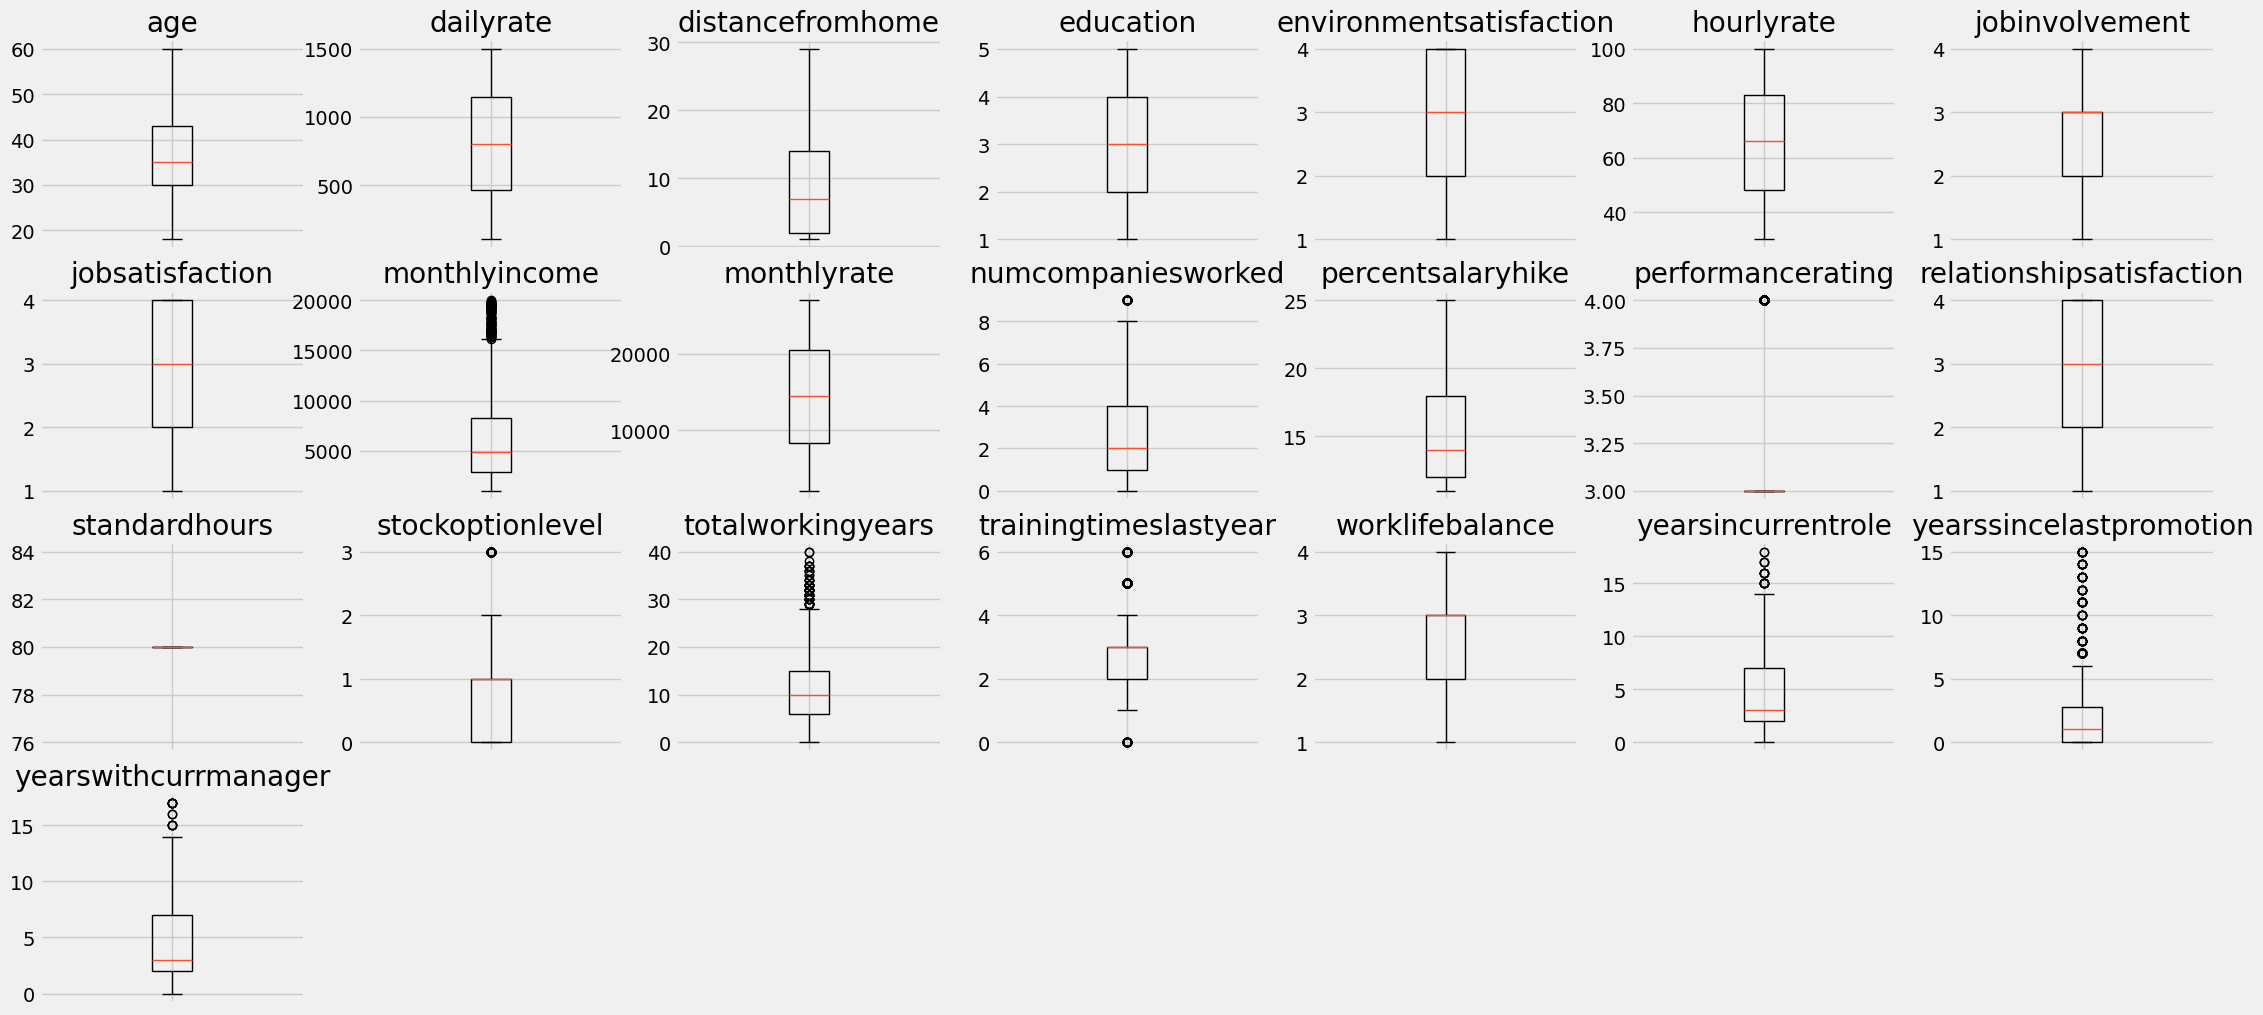

In [378]:
# Check for outliers
# YOUR CODE HERE
plt.figure(figsize=(25, 15))
for i, col in enumerate(numerical):
    plt.subplot(5, 7, i+1)
    plt.boxplot(df_attrition_train[col])
    plt.title(col)
    plt.xticks([1], [''])


### Handling outliers

**Exercise 4: Use lower bound as 25% and upper bound as 75% to handle the outliers [0.5 Mark]**

In [379]:
# YOUR CODE HERE
def identify_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]

numeric_features = df_attrition_train.select_dtypes(include=[np.number]).columns.tolist()

# Identifying outliers in numeric features
outliers_dict = {feature: identify_outliers(df_attrition_train, feature) for feature in numeric_features}

# Displaying the number of outliers detected for each numeric feature
outliers_count = {feature: len(outliers) for feature, outliers in outliers_dict.items()}
outliers_count

{'age': 0,
 'dailyrate': 0,
 'distancefromhome': 0,
 'education': 0,
 'environmentsatisfaction': 0,
 'hourlyrate': 0,
 'jobinvolvement': 0,
 'jobsatisfaction': 0,
 'monthlyincome': 94,
 'monthlyrate': 0,
 'numcompaniesworked': 45,
 'percentsalaryhike': 0,
 'performancerating': 180,
 'relationshipsatisfaction': 0,
 'standardhours': 0,
 'stockoptionlevel': 68,
 'totalworkingyears': 55,
 'trainingtimeslastyear': 200,
 'worklifebalance': 0,
 'yearsincurrentrole': 17,
 'yearssincelastpromotion': 142,
 'yearswithcurrmanager': 13}

In [380]:
def cap_outliers(df, feature):
    lower_bound = df[feature].quantile(0.05)
    upper_bound = df[feature].quantile(0.95)
    df[feature] = np.where(df[feature] < lower_bound, lower_bound, df[feature])
    df[feature] = np.where(df[feature] > upper_bound, upper_bound, df[feature])

# Cap outliers in identified features
outlier_features = [
    'numcompaniesworked', 'performancerating', 'stockoptionlevel',
    'totalworkingyears', 'trainingtimeslastyear', 'yearsincurrentrole',
    'yearssincelastpromotion', 'yearswithcurrmanager'
]

for feature in outlier_features:
    cap_outliers(df_attrition_train, feature)


### Target label imbalance

**Exercise 5: Check if there is an imbalance in target label [0.5 Mark]**

**Hint:** Use value_counts()

In [381]:
# Count of unique values in Attrition column
# YOUR CODE HERE
df_attrition_train.attrition.value_counts()

,count
attrition,
No,981
Yes,189


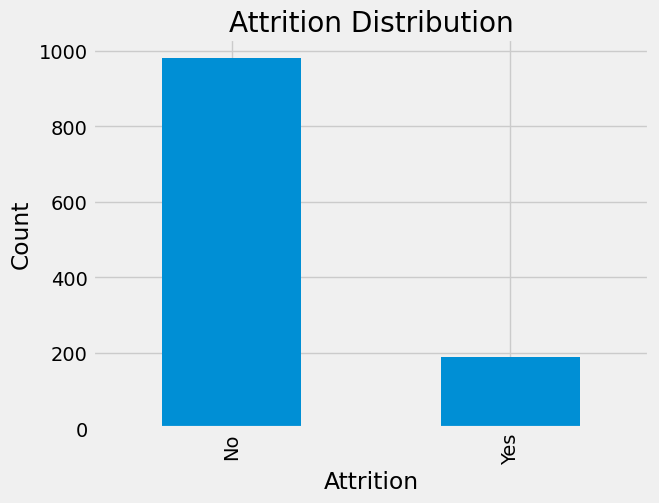

In [382]:
# Plot barplot to visualize balance/imbalance
# YOUR CODE HERE
df_attrition_train.attrition.value_counts().plot(kind='bar')
plt.title('Attrition Distribution')
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.show()  # Display the plot

If there is any imbalance in the dataset then a few techniques can be utilised (optional):
1. SMOTE
2. Cross Validation
3. Regularizing the model's parameters

###Plot pairplot

**Exercise 6: Visualize the relationships between the predictor variables and the target variable using a pairplot [0.5 Mark]**

**Hint:** Use sns.pairplot

In [383]:
# Visualize a pairplot with relevant features
# YOUR CODE HERE
#sns.pairplot(df_attrition_train, hue='attrition')
#plt.show()

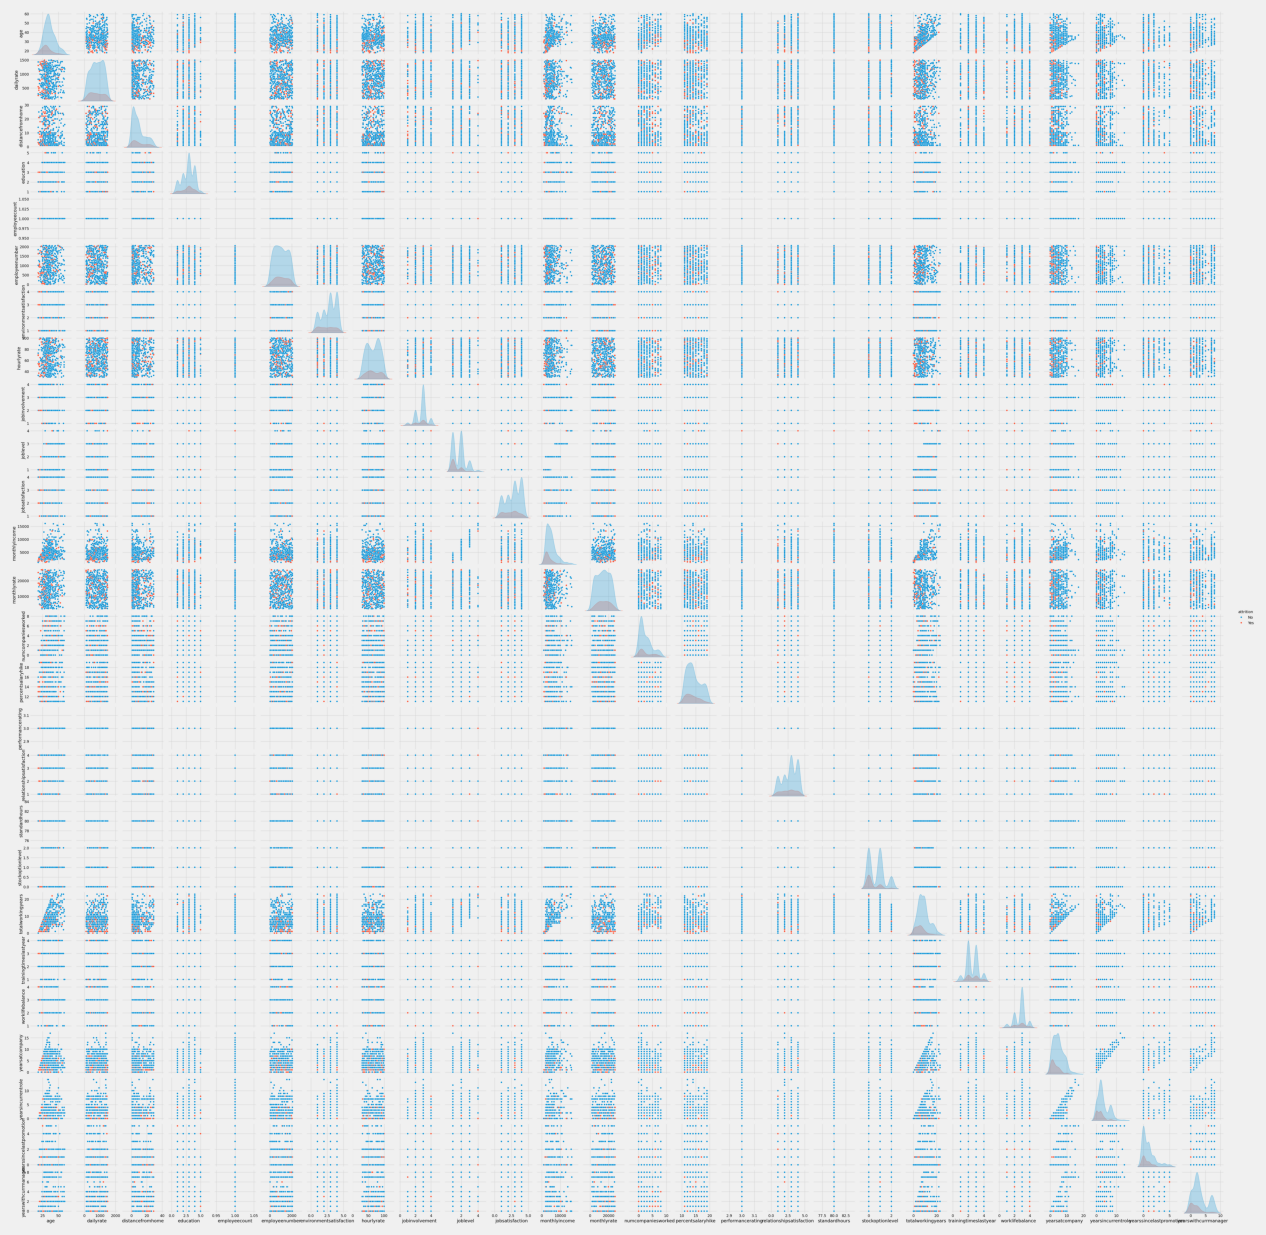

In [384]:
from PIL import Image
import matplotlib.pyplot as plt

# Specify the path to the image file in Google Drive
image_path = '/content/drive/MyDrive/ISC/MiniProject/M3_MP4_NB_Employee_Attrition_Prediction/pairplot.png'  # Replace with your image path

# Open and display the image
image = Image.open(image_path)
plt.figure(figsize=(25, 15))
plt.imshow(image)
plt.axis('off')  # Hide the axes
plt.show()

### Explore Correlation

- Plotting the Heatmap

**Exercise 7: Visualize the correlation among IBM employee attrition numerical features using a heatmap [0.5 Mark]**

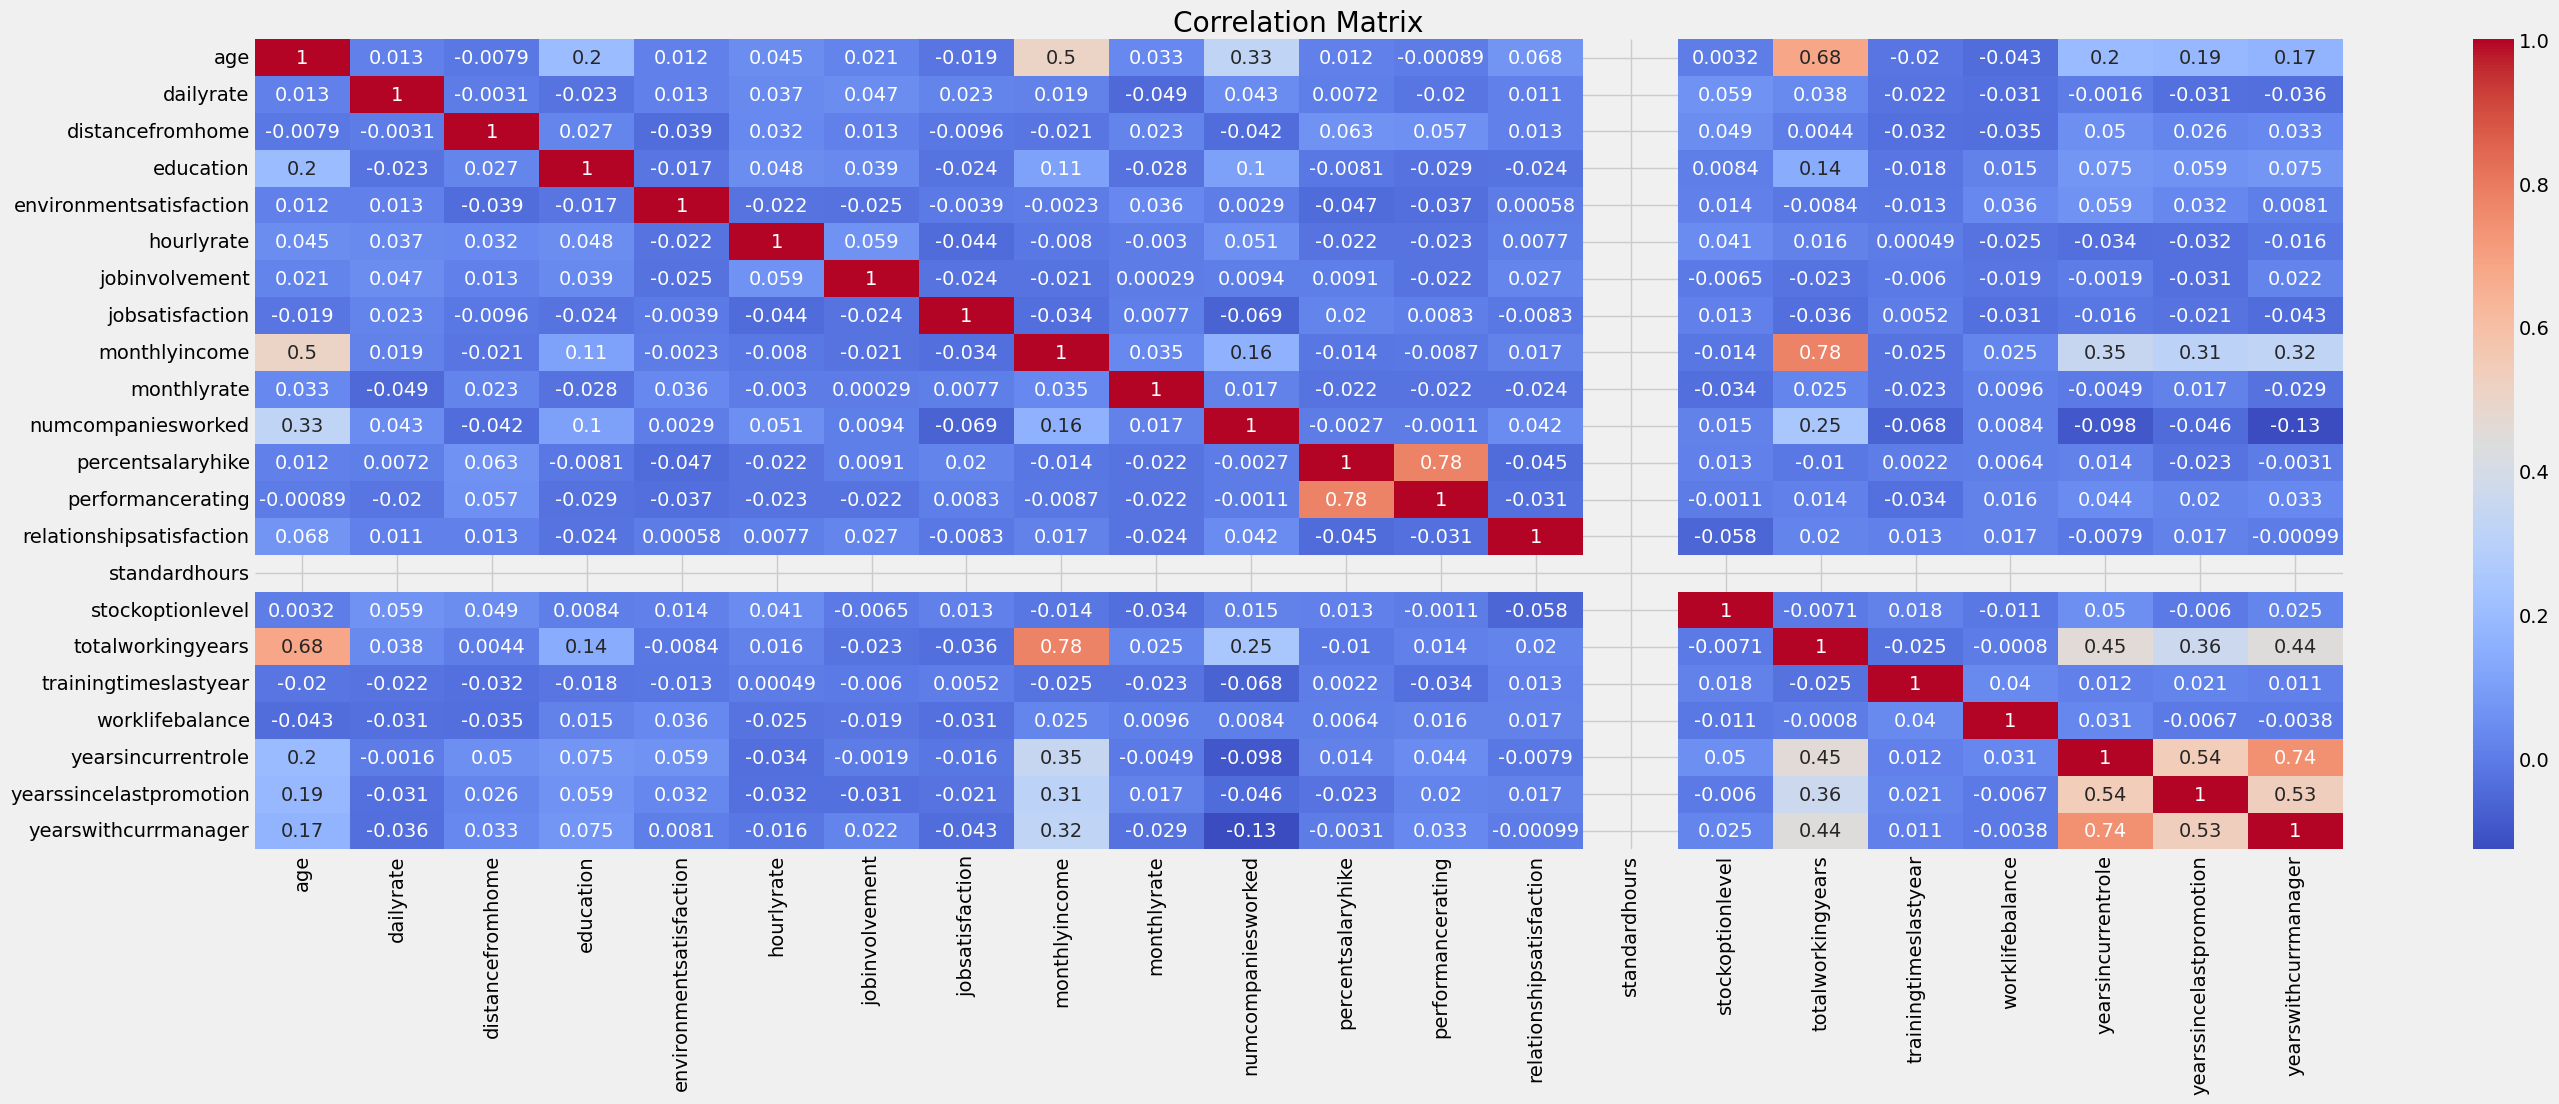

In [385]:
# Visualize heatmap
# YOUR CODE HERE
# Plot the correlation matrix
df_numerical = df_attrition_train.select_dtypes(include=['int64', 'float64'])
plt.figure(figsize=(30, 10))
correlation_matrix = df_numerical.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Comment on the observations made with the pairplot and heatmap

### Preparing the test feature space
* Remove outliers if any
* Handle the categorical feature if required
* Other processing steps can also be followed.

In [386]:
df_attrition_train.columns

Index(['age', 'businesstravel', 'dailyrate', 'department', 'distancefromhome',
       'education', 'educationfield', 'environmentsatisfaction', 'gender',
       'hourlyrate', 'jobinvolvement', 'jobrole', 'jobsatisfaction',
       'maritalstatus', 'monthlyincome', 'monthlyrate', 'numcompaniesworked',
       'overtime', 'percentsalaryhike', 'performancerating',
       'relationshipsatisfaction', 'standardhours', 'stockoptionlevel',
       'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance',
       'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager',
       'attrition'],
      dtype='object')

In [387]:
categorical_features = df_attrition_train.select_dtypes(include=['object']).columns.tolist()
categorical_features.remove('attrition')  # Exclude the target variable
# Apply one-hot encoding to all remaining categorical features
df_attrition_train = pd.get_dummies(df_attrition_train, columns=categorical_features, drop_first=True)
df_attrition_test = pd.get_dummies(df_attrition_test, columns=categorical_features, drop_first=True)

In [388]:
train_columns = set(df_attrition_train.columns)
test_columns = set(df_attrition_test.columns)
train_columns-test_columns, test_columns-train_columns

({'attrition'}, set())

In [389]:
df_attrition_train = df_attrition_train.sort_index(axis=1)
df_attrition_test = df_attrition_test.sort_index(axis=1)

# Convert target variable to integers
df_attrition_train['attrition'] = df_attrition_train['attrition'].map({'Yes': 1, 'No': 0})

# Split the training data into features and target variable
X = df_attrition_train.drop(columns=['attrition'])
y = df_attrition_train['attrition'].astype(int)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

# Initialize and train the CatBoost model

Optional:
Use `Hyperopt`, a hyperparameter tuning technique to identify the best set of parameters.

Refer to the Additional Notebook: CatBoost parameter tuning (CDS-B4 GDrive -> Module 2 -> Assignments -> Mar 04)

In the notebook, data processing is done separately for different models.
Considering the fact that different models may require data in different format and in turn different processes may be followed to process the data.

If the processing steps followed for the models are same, data processing can also be done once.

## Apply CatBoost

Catboost was released in 2017 by Yandex, showing, by their benchmark to be faster in prediction, better in accuracy, and easier to use for categorical data across a series of GBDT tasks. Additional capabilities of catboost include plotting feature interactions and object (row) importance.

[Here](https://catboost.ai/en/docs/) is the official documentation of CatBoost

### Data Processing for CatBoost

**Exercise 8: Data processing for CatBoost [1 Mark]**
* **Copy the dataframe that was created after removing the outliers**
* **Handle the categorical features if required**
* **Create target column and feature space**

**Hint:** Column containing the information on attrition will be the target column.

In [390]:
# Copy the data
# YOUR CODE HERE
catboost_model = CatBoostClassifier(iterations=1000,
    learning_rate=0.1,
    depth=6,
    verbose=False,
    early_stopping_rounds=50)

### Model Definition

**Exercise 9: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use CatBoostClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model. Refer [here](https://catboost.ai/en/docs/concepts/speed-up-training) to see some ways to speedup CatBoost training.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [391]:
catboost_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_catboost = catboost_model.predict(X_val)
catboost_accuracy = accuracy_score(y_val, y_val_pred_catboost)
print(f'CatBoost Model Accuracy: {catboost_accuracy}')

CatBoost Model Accuracy: 0.8839590443686007


In [392]:
# Create CatBoost model
# YOUR CODE HERE
# Define the CatBoost model with relevant parameters
# catboost_model = CatBoostClassifier(
#     iterations=1000,
#     learning_rate=0.1,
#     depth=6,
#     cat_features=categorical_features_indices,
#     verbose=100,
#     early_stopping_rounds=50
# )

In [393]:
# Model training
# YOUR CODE HERE
# catboost_model.fit(X_train, y_train)
# # Make predictions
# y_pred = catboost_model.predict(X_test)
# y_pred_proba = catboost_model.predict_proba(X_test)[:, 1]

### Model performance

In [394]:
# Model performance on all sets
# YOUR CODE HERE

## Apply XGBoost

XGBoost is a workhorse gradient boosted decision tree algorithm. Its been around since 2014 and has come to dominate the Kaggle and data science community. XGB introduced gradient boosting where new models are fit to the residuals of prior models and then added together, using a gradient descent algorithm to minimize the loss.

Read [here](https://xgboost.readthedocs.io/en/stable/parameter.html) on XGBoost parameters.

Refer [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) for the official documentation of XGBoost classifier.

### Data Processing for XGBoost


**Exercise 10: Data Processing for XGBoost [1 Mark]**
* **Copy the dataframe after the outliers were removed.**
* **Handle the categorical features if required**
* **Create target column and feature space**

In [395]:
# Copy dataframe
# YOUR CODE HERE
xgboost_model = XGBClassifier(n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

**Hint:** Use pd.get_dummies

In [396]:
# Handling categorical features
# YOUR CODE HERE
# Predict on the validation set
y_val_pred_xgboost = xgboost_model.predict(X_val)

# Evaluate the XGBoost model
xgboost_accuracy = accuracy_score(y_val, y_val_pred_xgboost)
print(f'XGBoost Model Accuracy: {xgboost_accuracy}')

XGBoost Model Accuracy: 0.8805460750853242


In [397]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE


When creating the dummy variables, the name of attrition column was changed, rename to 'attrition' again.

**Hint:** Use .rename

In [398]:
# Rename target column
# YOUR CODE HERE


In [399]:
# Feature Space
# YOUR CODE HERE
# Targer label


In [400]:
X.head(2)

,age,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,dailyrate,department_Research & Development,department_Sales,distancefromhome,education,educationfield_Life Sciences,educationfield_Marketing,educationfield_Medical,educationfield_Other,educationfield_Technical Degree,environmentsatisfaction,gender_Male,hourlyrate,jobinvolvement,jobrole_Human Resources,jobrole_Laboratory Technician,jobrole_Manager,jobrole_Manufacturing Director,jobrole_Research Director,jobrole_Research Scientist,jobrole_Sales Executive,jobrole_Sales Representative,jobsatisfaction,maritalstatus_Married,maritalstatus_Single,monthlyincome,monthlyrate,numcompaniesworked,overtime_Yes,percentsalaryhike,performancerating,relationshipsatisfaction,standardhours,stockoptionlevel,totalworkingyears,trainingtimeslastyear,worklifebalance,yearsincurrentrole,yearssincelastpromotion,yearswithcurrmanager
0,45,False,True,556,True,False,25,2,True,False,False,False,False,2,False,93,2,False,False,False,True,False,False,False,False,4,True,False,5906,23888,0.0,False,13,3.0,4,80,2.0,10.0,2.0,2,8.0,3.0,8.0
1,34,False,True,970,True,False,8,2,False,False,True,False,False,2,False,96,3,False,False,False,False,False,False,False,False,3,False,True,6142,7360,3.0,False,11,3.0,4,80,0.0,10.0,2.0,3,1.0,4.0,3.0


### Model Definition

**Exercise 11: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use XGBClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [401]:
# Create XGBoost classifier model
# YOUR CODE HERE
# Split the data into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Define the XGBClassifier model with relevant parameters
# xgb_model = XGBClassifier(
#     n_estimators=1000,
#     learning_rate=0.1,
#     max_depth=6,
#     early_stopping_rounds=50,
#     use_label_encoder=False,
#     eval_metric='logloss'
# )

In [402]:
# Model training
# YOUR CODE HERE
# xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=100)

### Model Performance

In [403]:
# Model performance on all sets
# YOUR CODE HERE


## Apply LightGBM (Optional)

LightGBM is an open-source GBDT framework created by Microsoft as a fast and scalable alternative to XGB and GBM. By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).

To know more about LightGBM parameters, refer [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier).

### Feature Engineering for LightGBM

In [404]:
lightgbm_model = LGBMClassifier(n_estimators=1000,
    learning_rate=0.1,
    max_depth=6,random_state=42)
lightgbm_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_lightgbm = lightgbm_model.predict(X_val)

# Evaluate the LightGBM model
lightgbm_accuracy = accuracy_score(y_val, y_val_pred_lightgbm)
print(f'LightGBM Model Accuracy: {lightgbm_accuracy}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 143, number of negative: 734
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1081
[LightGBM] [Info] Number of data points in the train set: 877, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163056 -> initscore=-1.635664
[LightGBM] [Info] Start training from score -1.635664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

### Model Definition

**Hint:**
* Use LGBMClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [405]:
# Create LightGBM classifier model
# YOUR CODE HERE


In [406]:
# Model training
# YOUR CODE HERE
# Fit the model to the training data


### Model performance

In [407]:
# Model performance on all sets
# YOUR CODE HERE
# Make predictions
# Evaluate the model


## Results

**Exercise 12: Create a dataframe of XGBoost results and CatBoost results and display them [0.5 Mark]**

**Hint:** Use pd.DataFrame

In [408]:
# Create a dataframe for computed metrics for different models
# YOUR CODE HERE
# results_df = pd.DataFrame({
#     'Model': ['XGBoost', 'CatBoost', 'LGBMClassifier'],
#     'ROC AUC Score': [xgboost_roc_auc, catboost_roc_auc, lgbm_roc_auc],
#     'Accuracy': [xgboost_accuracy, catboost_accuracy, lgbm_accuracy],
#     'F1 Score': [xgboost_f1, catboost_f1, lgbm_f1]
# })

In [409]:
#results_df

Reference reading:
1. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/

## Kaggle Prediction

Load data from Kaggle competition site

In [410]:
# From the given Kaggle competition link, load the dataset 'hr_employee_attrition_test.csv'
# YOUR CODE HERE


In [411]:
#df_kaggle.dtypes

In [412]:
# From the dataset 'hr_employee_attrition_test.csv', drop columns ['id','employeenumber', 'employeecount', 'over18'] having single value
# YOUR CODE HERE
#df_kaggle.drop(columns=['id','employeenumber', 'employeecount', 'over18'], inplace=True)


In [413]:
# Handle categorical features
# YOUR CODE HERE


In [414]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE (Already Done)
# Ensure all dummy columns are numeric (0/1)


Predictions

In [415]:
# Get the predictions using your already trained CatBoost classifier model achieved in Exercise 9
# YOUR CODE HERE
catboost_predictions = catboost_model.predict(df_attrition_test)
submission = pd.DataFrame({'id': test_ids, 'label': catboost_predictions})
submission.to_csv('catboost_Sample_Submission.csv', index=False)

In [416]:
# Get the predictions using your already trained XGBoost classifier model achieved in Exercise 11
# YOUR CODE HERE
xgb_predictions = xgboost_model.predict(df_attrition_test)
submission = pd.DataFrame({'id': test_ids, 'label': xgb_predictions})
submission.to_csv('xgb_Sample_Submission.csv', index=False)

Get the predictions using your trained Microsoft LightGBM model (Optional)

In [417]:
# Get the predictions using your already trained Microsoft LightGBM classifier model
# achieved under the optional exercise 'Apply LightGBM (Optional)'
# YOUR CODE HERE
lgb_predictions = lgb_model.predict(df_attrition_test)
submission = pd.DataFrame({'id': test_ids, 'label': lgb_predictions})
submission.to_csv('lgb_Sample_Submission.csv', index=False)

Save predictions to csv and submit under given Kaggle competiton link

In [418]:
# YOUR CODE HERE